# Forecasting with machine learning

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

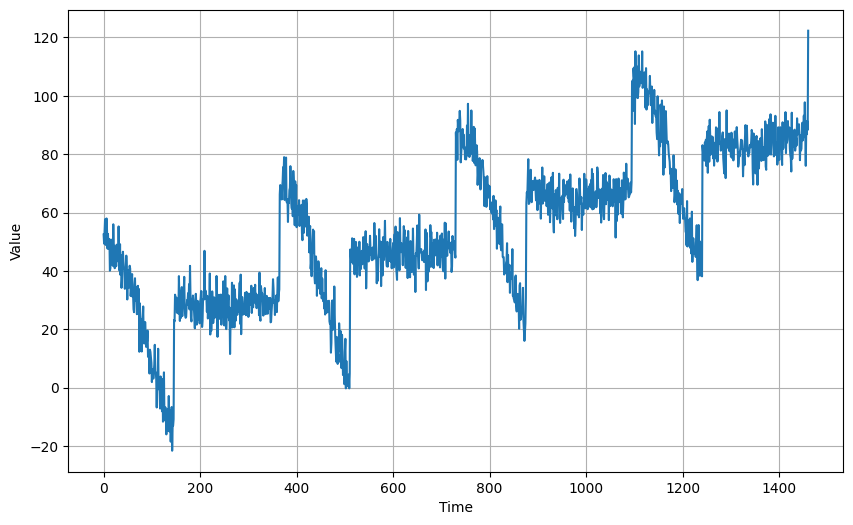

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 77.8732 - mae: 78.3730 - val_loss: 106.3696 - val_mae: 106.8696
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 38.9323 - mae: 39.4312 - val_loss: 33.2475 - val_mae: 33.7464
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 11.1674 - mae: 11.6575 - val_loss: 9.4859 - val_mae: 9.9760
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 9.0956 - mae: 9.5802 - val_loss: 8.7189 - val_mae: 9.2007
Epoch 5/100
31/31 [==============================] - 1s 11ms/step - loss: 8.9716 - mae: 9.4558 - val_loss: 8.4406 - val_mae: 8.9279
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 8.9328 - mae: 9.4174 - val_loss: 8.4085 - val_mae: 8.8951
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 8.9075 - mae: 9.3909 - val_loss: 8.5456 - val_mae: 9.0348
Epoch 8/100
31/31 [==============================] - 1s 17ms/step -

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 3s 33ms/step - loss: 30.7250 - mae: 31.2214 - val_loss: 18.5046 - val_mae: 19.0011
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 10.5452 - mae: 11.0314 - val_loss: 8.9508 - val_mae: 9.4331
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 9.8115 - mae: 10.3016 - val_loss: 8.6918 - val_mae: 9.1765
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 9.6475 - mae: 10.1362 - val_loss: 8.7711 - val_mae: 9.2527
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 9.4871 - mae: 9.9756 - val_loss: 8.3880 - val_mae: 8.8759
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 9.3177 - mae: 9.8058 - val_loss: 8.2707 - val_mae: 8.7566
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 9.1861 - mae: 9.6743 - val_loss: 8.1041 - val_mae: 8.5908
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 8

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


In [12]:
lin_forecast.shape

(461,)

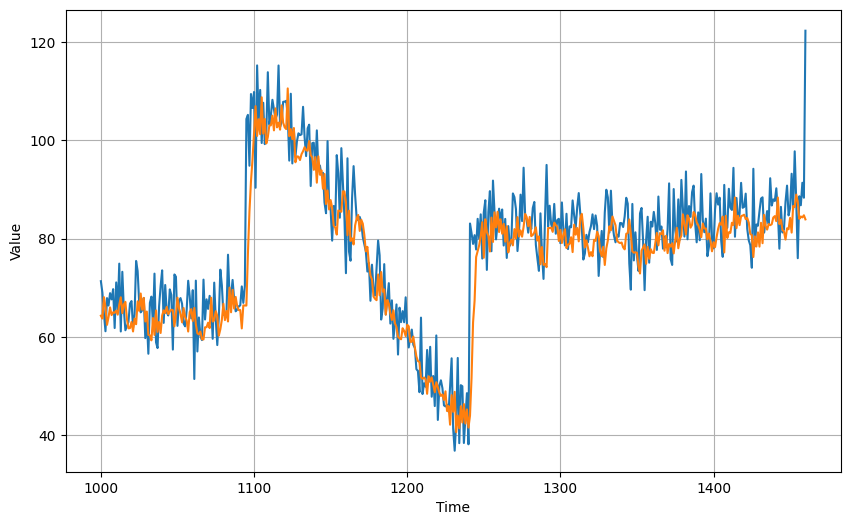

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.111682

### Dense Model Forecasting

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 10.4339 - mae: 10.9239 - val_loss: 10.0830 - val_mae: 10.5729
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 8.2076 - mae: 8.6908 - val_loss: 8.6381 - val_mae: 9.1299
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 7.6974 - mae: 8.1805 - val_loss: 7.3544 - val_mae: 7.8331
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 6.9740 - mae: 7.4528 - val_loss: 6.8500 - val_mae: 7.3337
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 6.1705 - mae: 6.6513 - val_loss: 6.3956 - val_mae: 6.8826
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 5.6965 - mae: 6.1758 - val_loss: 5.3883 - val_mae: 5.8679
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 5.3597 - mae: 5.8406 - val_loss: 5.2330 - val_mae: 5.7092
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 5.120

In [16]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


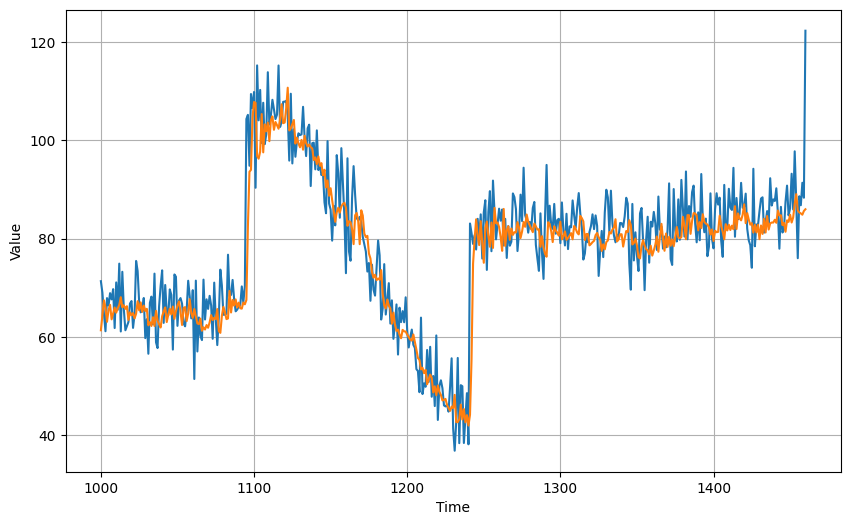

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [18]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

4.827314